# How PSETAE model works

## Table of Contents

* [Satellite image time series](#Satellite-image-time-series)
* [Prepare training data for satellite image time series](#Prepare-training-data-for-satellite-image-time-series)
* [Architecture](#Architecture)
  * [Pixel-set encoder](#Pixel-set-encoder)
  * [Temporal attention encoder](#Temporal-attention-encoder)
  * [Spectro-temporal classifier](#Spectro-temporal-classifier)
* [Implementation in arcgis.learn](#Implementation-in-arcgis.learn) 
* [Summary](#Summary)
* [References](#References)

## Satellite image time series

Earth observation time series is referred to as collection of satellite images of a location from different time-periods, stacked vertically resulting in a 3-dimensional structure. The collection has a common projection and a consistent timeline. Each location in the space-time is a vector of values across a timeline as shown in figure 1:

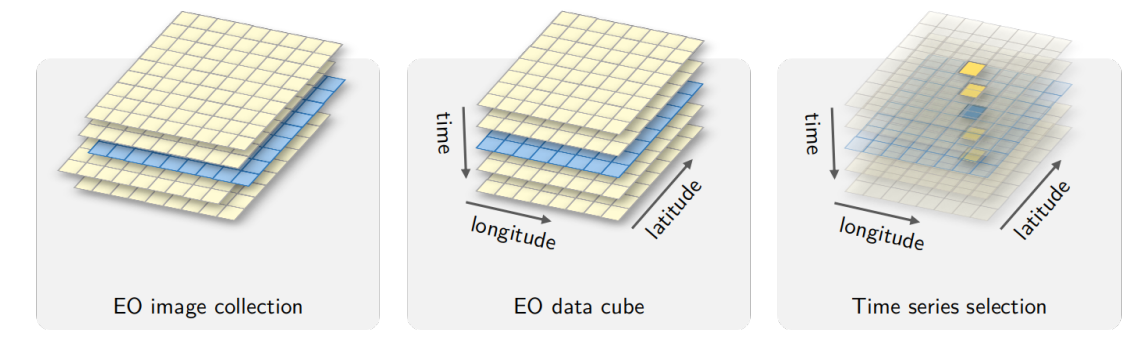

<center> Figure 1. Time-series of satellite imagery. [2] </center>

Combination of temporal component with spectral information allow for detection and classification of complex pattern in various applications such as crop type and condition classification, mineral and land-cover mapping etc.

In this guide, we will focus on `PSETAE`, a transformer based deep learning model originally developed by [Garnot et al](https://openaccess.thecvf.com/content_CVPR_2020/papers/Garnot_Satellite_Image_Time_Series_Classification_With_Pixel-Set_Encoders_and_Temporal_CVPR_2020_paper.pdf) for agricultural parcels classification into different crop types in satellite image time-series.

## Prepare training data for satellite image time series

The [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to export training data for the model. The input satellite time-series is a [composite](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/composite-bands.htm) of rasters or [multi-dimensional raster](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm) from the required time periods or time steps. Here are the [steps](https://www.youtube.com/watch?v=HFbTFTnsMWM), to create multi-dimensional raster from collection of images. 

Training labels can be created using the [Label objects for deep learning](https://pro.arcgis.com/en/pro-app/latest/help/analysis/image-analyst/label-objects-for-deep-learning.htm#:~:text=The%20Label%20Objects%20for%20Deep,is%20divided%20into%20two%20parts.) tool available inside `Classification Tools`. Pixels are labelled into different classes, based on the available information. Labelling of different crop types are shown in the figure. 

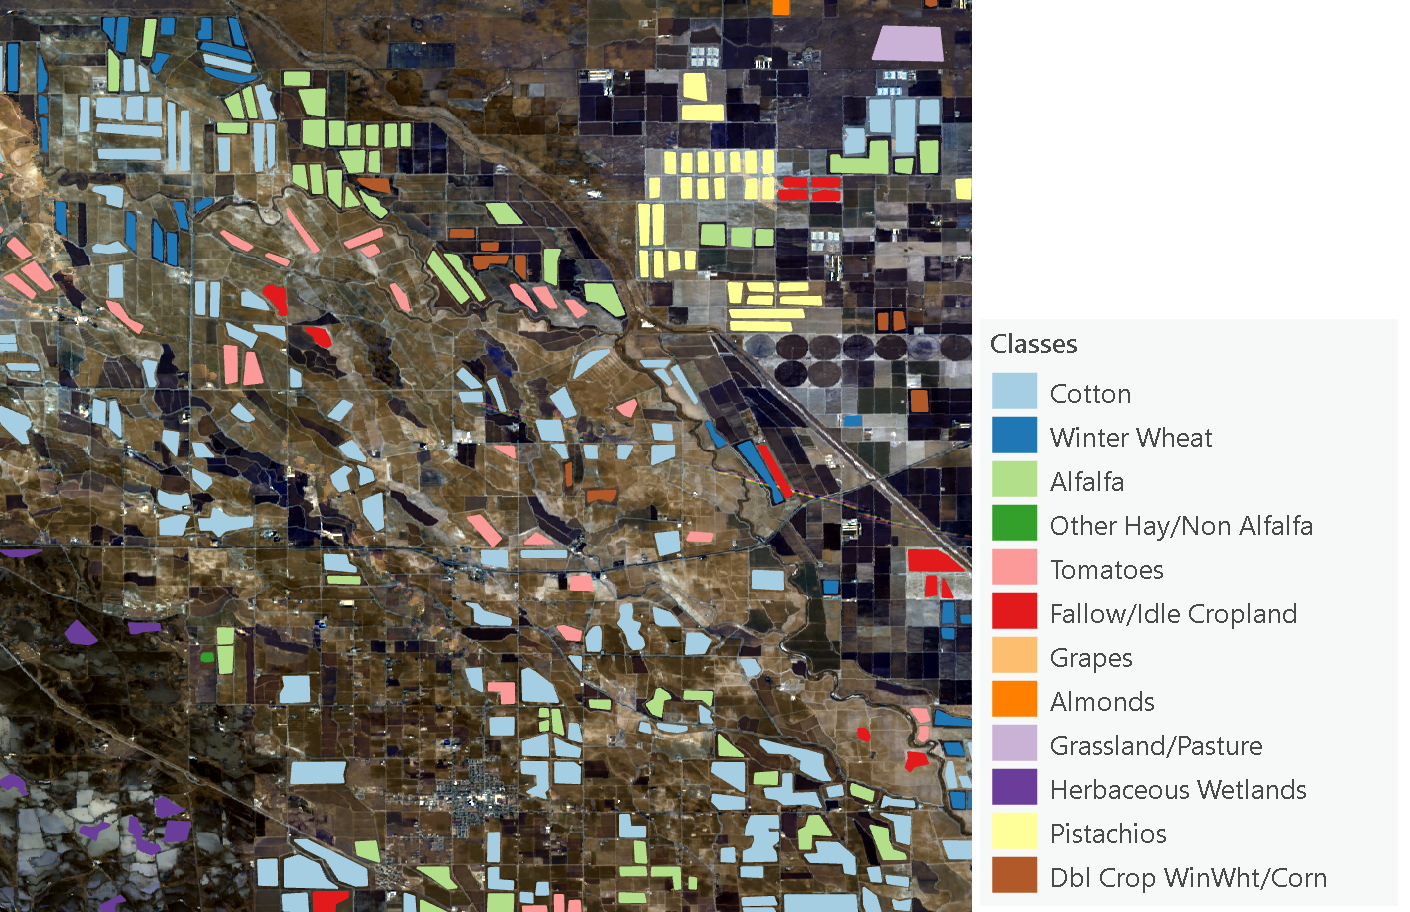

<center> Figure 2. Samples of labels from different classes overlayed on time-series raster  </center> 

## Architecture

`PSETAE` model architecure is based on transfomers, originally developed for sequence-to-sequence modeling. The proposed architecture encodes time-series of multi-spectral images. The pixels under each class label is given by spectro-temporal tensor of size T x C x N, where T the number of temporal observation, C the number of spectral channels, and N the number of pixels.  

The architecture of `PSETAE` model consists of a pixel-set encoder, temporal attention encoder and, classifier. The components are briefly described in following sections.

### Pixel-set encoder

The study suggests that, convolution operations may not be suitable for the detection of the various classes from images with high spectral variations across time. CNNs were also observed to be memory intensive.

To overcome this issue, the authors proposed pixel-set encoder (PSE). PSE uses a sample set of pixels from time-series raster, which is processed through a series of shared MLP(Fully Connected, Batch Norms, Rectified Linear Units) layers. This allows the architecture to learn about the statistical descriptors of a particular class's pixel's spectral distribution. The output is a spectral embedding for set a pixels of a class at time t.

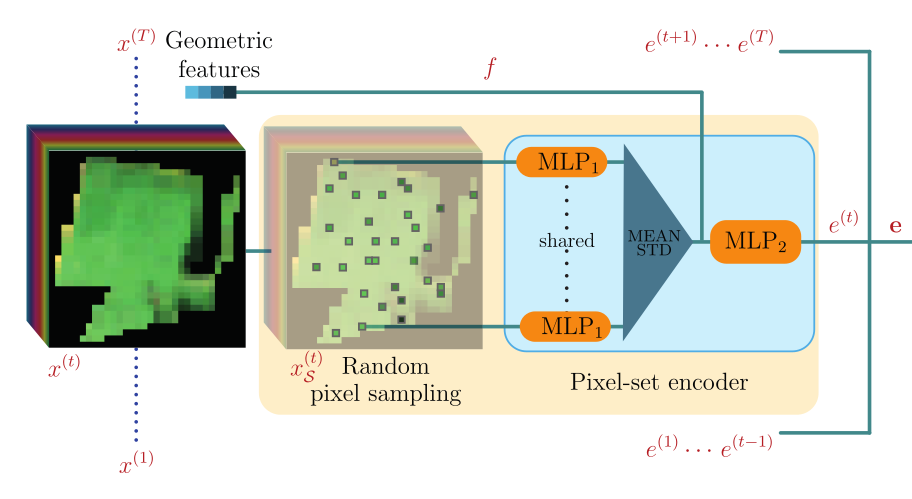

<center> Figure 3. Pixel-Set Encoder. [1] </center> 

### Temporal attention encoder

This component is based on the state-of-the-art transformer used originally for dealing with sequential data from [Vaswani et al.](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). After multi-channel spectral embedding at time t by pse, the temporal attention encoder (tae) tries to find embedding for each parcel's time-series. The authors made the following changes to original transformers:

- The pre-trained word embedding model used in the original mode is replaced by PSE's spectral embedding.
- The positional encoder uses the first obervation or date to calculate number of days to other dates. This helps the model to take in account the variance in temporal observations.
- The goal is to encode the whole time-series into single embedding, rather then generate one for each element of sequence. To achieve this, query tensors generated by the each attention heads are pooled into single master query.

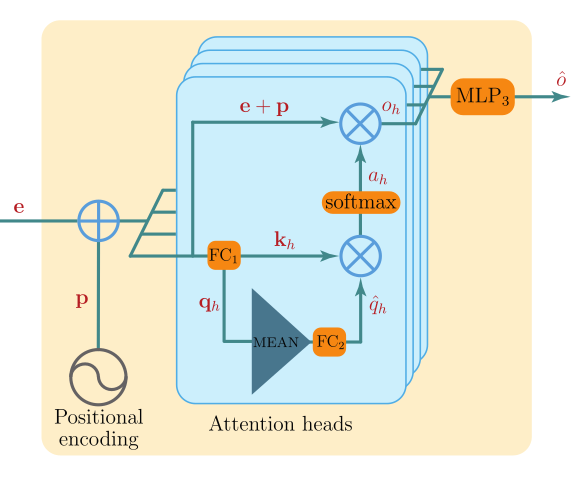

<center> Figure 4. Temporal Attention Encoder. [1] </center> 

### Spectro-temporal classifier

Shared PSE embeds all input time-series rasters in parallel and the resulting embedded sequence is processed by temporal encoder. The resulting embedding is processed by an mlp to produice class logits. Spectro-temporal classifier combines PSE and TAE with a final MLP layer to produce class logits. 

For further information on the model's architecture, refer to [paper](https://openaccess.thecvf.com/content_CVPR_2020/papers/Garnot_Satellite_Image_Time_Series_Classification_With_Pixel-Set_Encoders_and_Temporal_CVPR_2020_paper.pdf).

## Implementation in `arcgis.learn`

Input Raster - time-series raster is a [composite](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/composite-bands.htm) or [multi-dimensional](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm) raster from the required time periods or time steps. 

Export - use the input raster to export the raster chips in `RCNN Masks` metadata format using [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool available in `ArcGIS Pro`. The resulting path from from export tool is provided to [prepare_data](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#prepare-data) function in `arcgis.learn` to create a databunch.

`data = prepare_data(path=r"path/to/exported/data", n_temporal, min_points, batch_size, n_temporal_dates, dataset_type="PSETAE")`
                    
where,

- `n_temporal` - Optional for multi-dimensional, required for composite raster. Number of temporal observations or time steps or number of composited rasters. 
- `min_points` - Optional. Number of pixels equal to or multiples of 64 to sample from the each labelled region of training data i.e. 64, 128, etc.
- `batch_size` - Optional. Suggested batch size for this model is around 128.
- `n_temporal_dates` - Optional for multi-dimensional, required for composite raster. The dates of the observations will be used for the positional encoding and should be stored as a list of date strings in YYYY-MM-DD format.
- `dataset_type` - Required. Type of dataset in-sync with the model.

By default, initialization of the `PSETAE` object as shown below:

`model = arcgis.learn.PSETAE(data)`

model parameters that can be passed using keyword arguments:

* `mlp1` - Optional list. Dimensions of the successive feature spaces of MLP1. default set to `[32, 64]`.
* `pooling` - Optional string. Pixel-embedding pooling strategy, can be chosen in ('mean','std','max','min'). default set to 'mean'.
* `mlp2` - Optional list. Dimensions of the successive feature spaces of MLP2. default set to `[128, 128]`.
* `n_head` - Optional integer. Number of attention heads. default set to 4.
* `d_k` - Optional integer. Dimension of the key and query vectors. default set to 32.
* `dropout` - Optional float. dropout. default set to 0.2.
* `T` - Optional integer. Period to use for the positional encoding. default set to 1000.
* `mlp4` - Optional list. dimensions of decoder mlp .default set to `[64, 32]`.

Default values for optimal performance are set for model's hyperparmeters. 

Here, `data` is the object returned from `prepare_data` function.

For more information about the API, please go through the [API reference](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

## References

- [1] Garnot, Vivien Sainte Fare, Loic Landrieu, Sebastien Giordano, and Nesrine Chehata. "Satellite image time series classification with pixel-set encoders and temporal self-attention." In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 12325-12334. 2020.
- [2] Simoes, Rolf, Gilberto Camara, Gilberto Queiroz, Felipe Souza, Pedro R. Andrade, Lorena Santos, Alexandre Carvalho, and Karine Ferreira. "Satellite image time series analysis for big earth observation data." Remote Sensing 13, no. 13 (2021): 2428.